
<center> <h1> N-DIMENZIONALNA TENZORSKA FAKTORIZACIJA ZA KONTEKSTNO ZAJEDNIČKO FILTRIRANJE </h1> </center>

<br>


<center> <i>Bratulić Petar, Stanišić Matea </i> </center>

<br>




<img src="hosvd.png">

Cilj korištenja <i><b>TF</b></i>-a za kontekstno zajedničko filtriranje je integracija konteksta u model na isti način kako su integrirani korisnici i sadržaj u model matrične faktortizacije. Odnosno, proučavaju se poveznice između različitih korisnika, sadržaja i konteksta. Ovaj pristup u literaturi naziva se _Višesvjetne preporuke_ iz razloga što efikasno spaja "<i>skrivene svjetove</i>" odvojene različitim kontekstom.

U usporedbi s kontekstnim metodama za sugeriranje sadržaja, <i>višesvjetne preporuke</i> imaju sljedeće prednosti:
*  <i>Nema potrebe za prethodnim ili naknadnim filtriranjem</i> <br>
    Mnogi algoritmi za kontekstno filtriranje oslanjaju se na podjelu podataka te _prethodnim ili naknadnim filtriranjem_ u odnosu na kontekst koji mogu voditi do gubitka informacija o povezanosti između različitih kontekstnih okolonosti. Nasuprot tome, <i><b>TF</b></i> koristi sve dostupne ocjene za modeliranje korisnika i sadržaja. 
* _Jednostavnost izračunavanja_ <br>
    Mnoge metode oslanjaju se na niz tehnika koje su često budu skupe za izračunavanje, dok <i><b>TF</b></i> koristi jednu, jednostavniju tehniku izračunavanja.
*  _Mogućnost baratanja s $N$ dimenzija_ <br>
   <i><b>TF</b></i>  uvodi proizvoljan broj kontekstualnih varijabli i pri tome vrlo malo povećava kompleksnost.


<br>


***



<br><br>

In [45]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
import math

<br><br>

## YAHOO MOVIE DATA

<br>

#### analiza filmova

In [46]:
yahoo_movies = pd.read_csv('yahoo_movies_context.txt', sep=";", header=None)
yahoo_movies.columns = ["movie_id","yahoo_id","name","year","movie_age"]
yahoo_movies.tail()

,movie_id,yahoo_id,name,year,movie_age
106956,106954,1808524892,The Saragossa Manuscript,1999.0,3
106957,106955,1808524895,For Ever Mozart,1997.0,3
106958,106956,1808524896,Northern Skirts,1999.0,3
106959,106957,1808524899,Valley of Tears,2003.0,3
106960,106958,1808525209,Morlang,2003.0,3


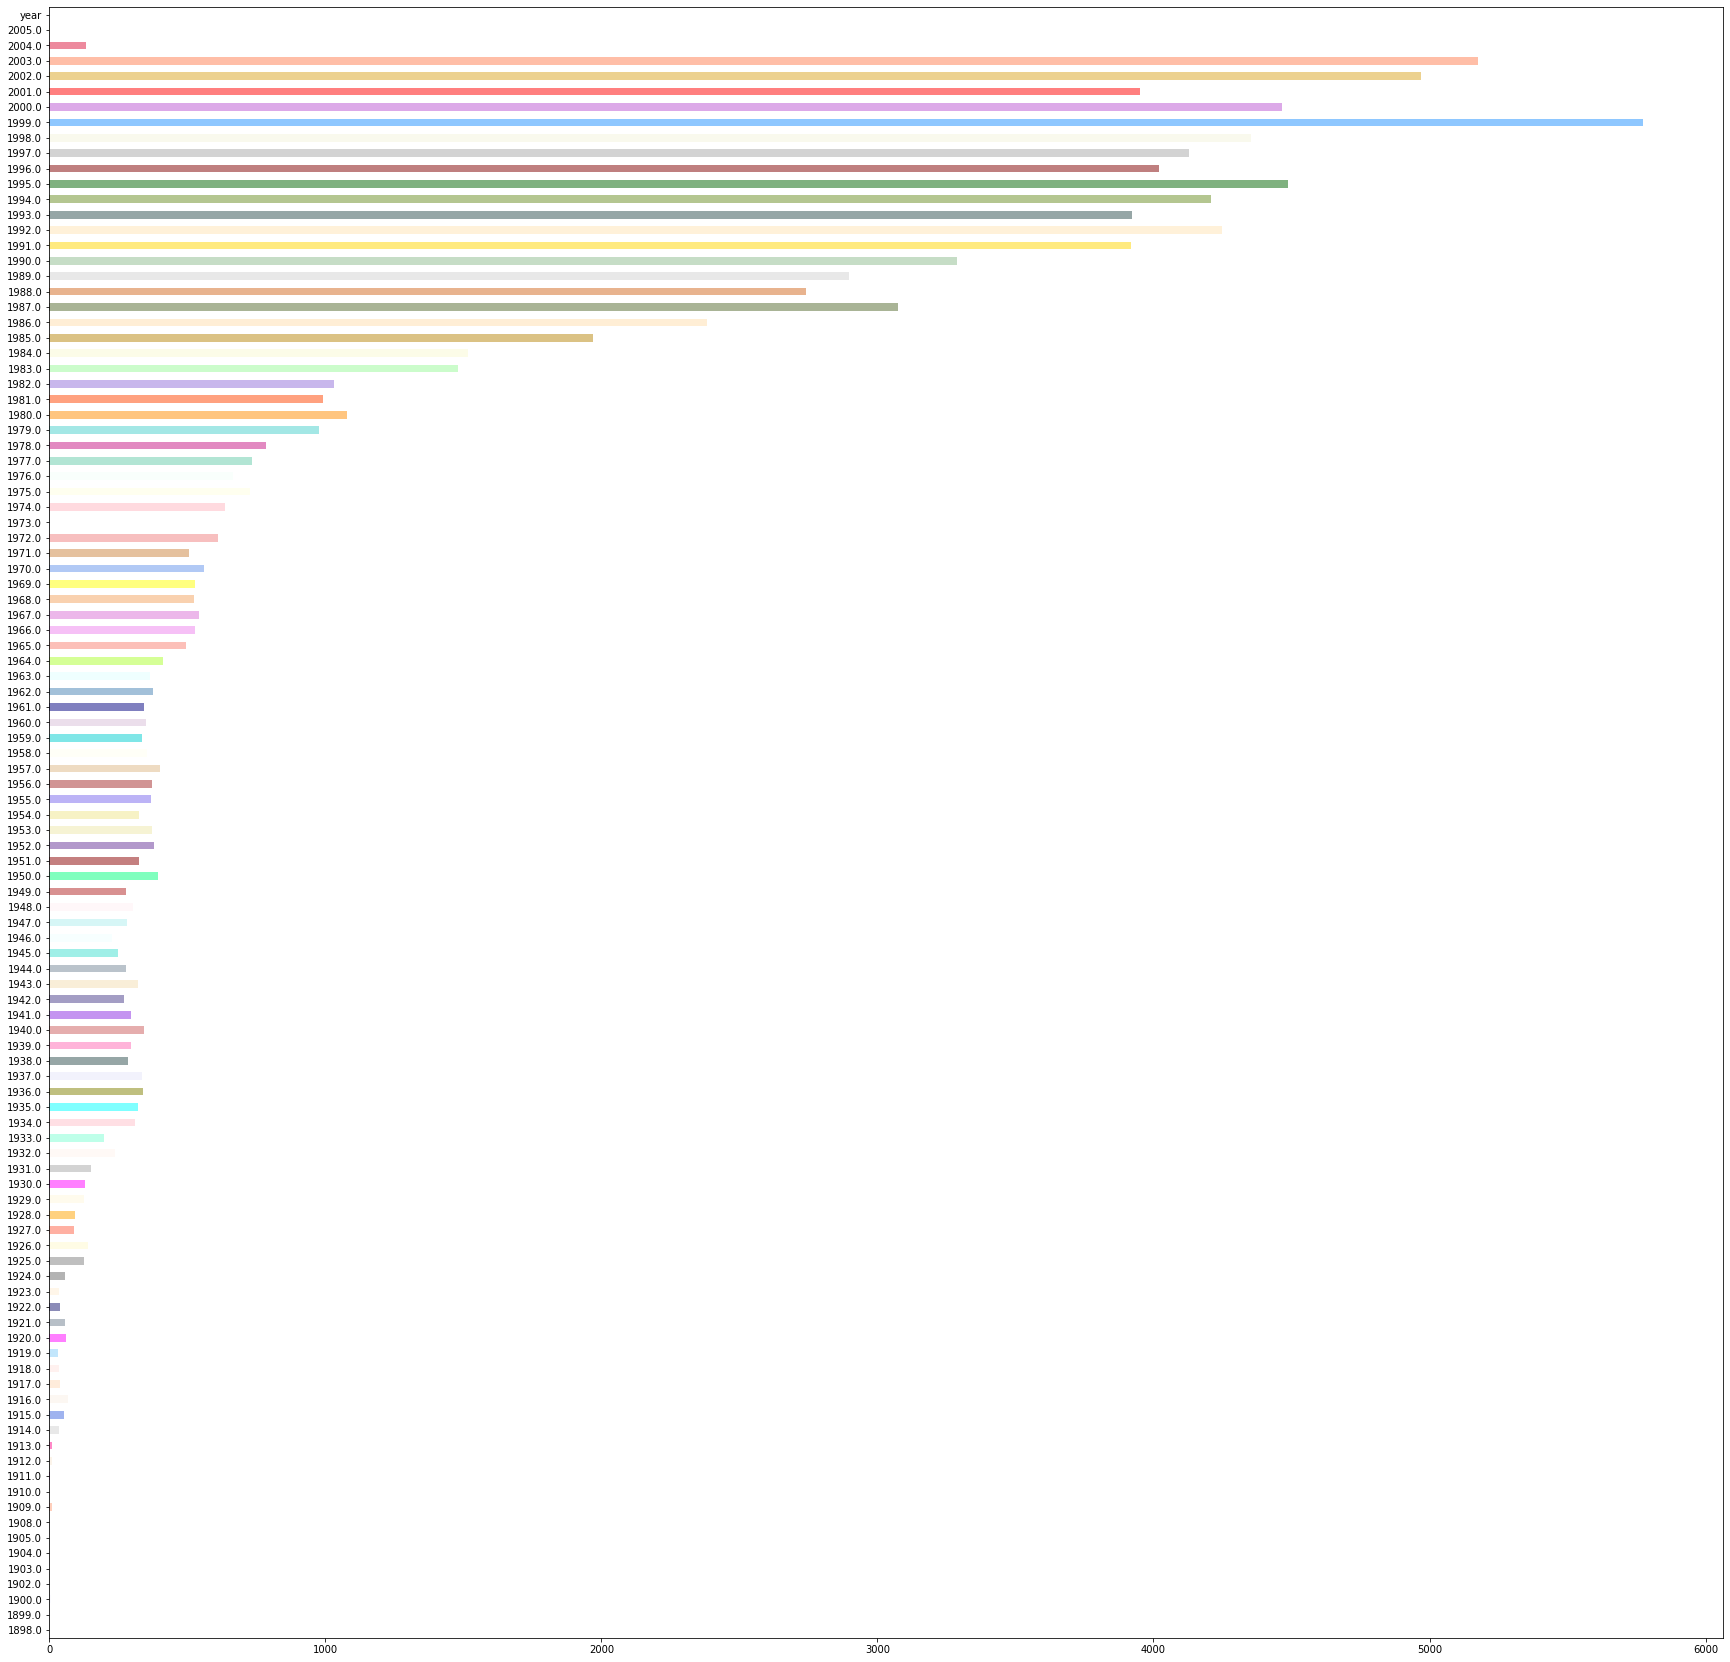

In [3]:
boje = list(mcolors.CSS4_COLORS.keys())
random.shuffle(boje)

yahoo_movies['year'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(30,30), stacked=True, color=boje)
plt.show()

Podijelimo filmove u tri skupine:
* _jako stari_ s oznakom '1' (do 1975.)
* _stari_ s oznakom '2' (1975.-1990.)
* _noviji_ s oznakom '3' (nakon 1990.)

In [ ]:
category = []

for index, row in yahoo_movies.iterrows():
    
    if math.isnan(row["year"]):
        category.append(-1)
        continue
        
    if int(row["year"]) >= 1990: 
        category.append(3)
        continue
        
    if int(row["year"]) >= 1975:
        category.append(2)
        continue
        
    category.append(1)
    
yahoo_movies['year_category'] = category
yahoo_movies

In [ ]:
yahoo_movies['year_category'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(30,30), stacked=True, color=["palegreen", "coral", "darkcyan"])
plt.show()

In [ ]:
#yahoo_movies.to_csv("yahoo_movies_context_yearcategory.csv", index = False, sep=";")

<br><br>





#### analiza korisnika

In [4]:
yahoo_users = pd.read_csv('yahoo_users_context.txt', sep=",", header=None)
yahoo_users.columns = ["user_id","born_year","gender"]
yahoo_users.head()

,user_id,born_year,gender
0,1,1979,f
1,2,1987,m
2,3,1988,f
3,4,1983,m
4,5,1988,m


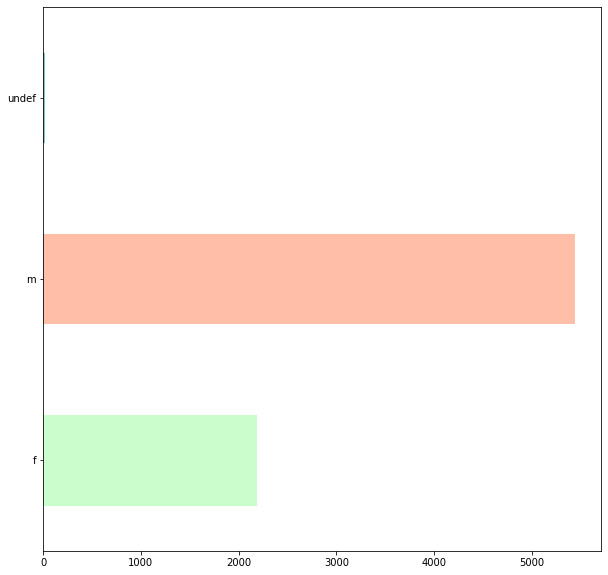

In [5]:
yahoo_users['gender'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(10,10), color=["palegreen", "coral", "darkcyan"])
plt.show()

In [6]:
undef_gender_users_ids = yahoo_users[yahoo_users["gender"] == "undef"]["user_id"].values.ravel()
undef_gender_users_ids

array([  40,  709,  887, 1151, 1845, 2491, 2642, 2703, 3183, 3267, 3556,
       3914, 4029, 4336, 5939, 6164, 6187, 6931, 7023, 7373, 7425, 7501],
      dtype=int64)

Vidimo da imamo $22$ korisnika za koje nam nije poznat spol kojem pripadaju. Kasnije ćemo vidjeti, da nam za te iste korisnike nije poznata niti godina rođenja. Također, primjetimo da imamo više korisnika muškog spola u bazi.

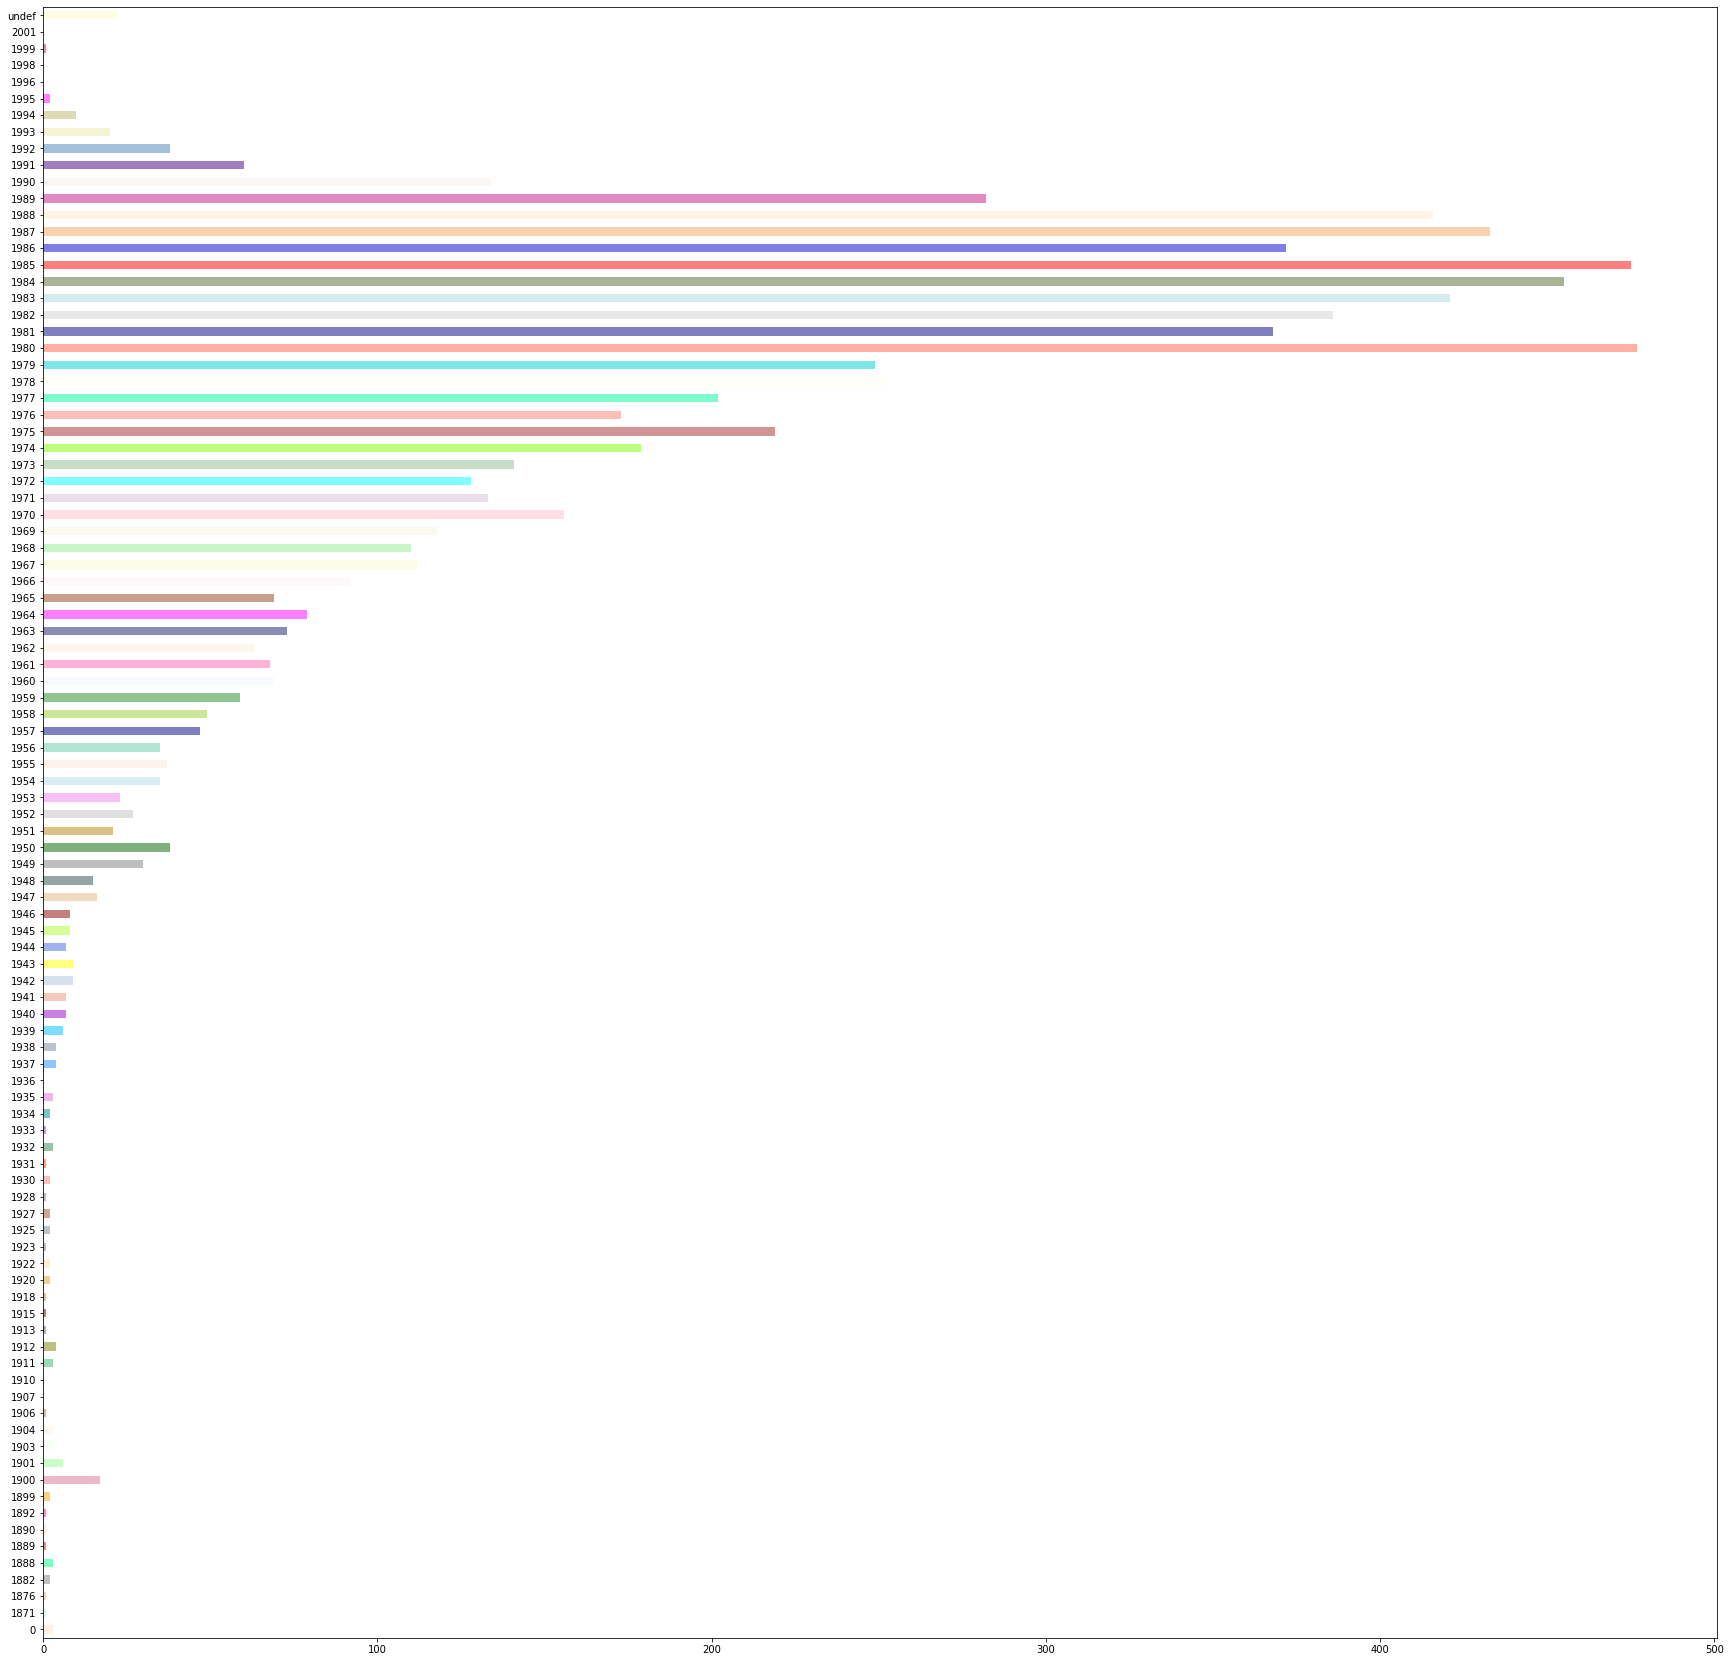

In [7]:
boje = list(mcolors.CSS4_COLORS.keys())
random.shuffle(boje)

yahoo_users['born_year'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(30,30), stacked=True, color=boje)
plt.show()

In [8]:
yahoo_users['born_year'].value_counts().shape

(98,)

In [9]:
undef_born_year_users_ids = yahoo_users[yahoo_users["born_year"] == "undef"]["user_id"].values.ravel()
undef_born_year_users_ids

array([  40,  709,  887, 1151, 1845, 2491, 2642, 2703, 3183, 3267, 3556,
       3914, 4029, 4336, 5939, 6164, 6187, 6931, 7023, 7373, 7425, 7501],
      dtype=int64)

In [10]:
undef_gender_users_ids == undef_born_year_users_ids

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Dakle, za $22$ korisnika nemamo informaciju o godini rođenja niti o njihovom spolu. Dvije su mogućnosti, nadopuniti te informacije sa prosječnim vrijednostima ili izbaciti njihove ocjene u skupu za treniranje kako nas oni ne bi doveli do krivog zaključka.

Također, nailazimo na još jedan problem - a to je godina rođenja označena sa $0$. S ocjenama takvih korisnika također treba biti oprezan. Takvih je troje.

In [11]:
zero_born_year_users_ids = yahoo_users[yahoo_users["born_year"] == "0"]["user_id"].values.ravel()
zero_born_year_users_ids

array([1689, 3091, 3664], dtype=int64)

<br>

Ovdje spremamo sve korisnike koje ćemo izostaviti iz skupa za treniranje.

In [12]:
leave_out_train_users = list(zero_born_year_users_ids) + list(undef_born_year_users_ids)
print(leave_out_train_users)

[1689, 3091, 3664, 40, 709, 887, 1151, 1845, 2491, 2642, 2703, 3183, 3267, 3556, 3914, 4029, 4336, 5939, 6164, 6187, 6931, 7023, 7373, 7425, 7501]


<br>

Podijelimo korisnike u $3$ skupine s obzirom na njihovu dob:
* _mladi_ s oznakom '1' (do 18 godina)
* _srednje dobi_ s oznakom '2' (19 do 40 godina)
* _stari_ s oznakom '3' ( više od 40 godina )

<br>

Kako je baza podataka filmova iz $2003.$ godine, to bi značilo raspodijelu po sljedećim godinama:
* [1985,>
* [1963,1984]
* <,1962]

In [13]:
category_users = []

for index, row in yahoo_users.iterrows():
    
    if (row["born_year"] == "undef"):
        category_users.append(-1) #zastavica da se radi o korisniku kojemu nije upisana godina rođenja
        continue
        
    cat = 3
    if int(row["born_year"]) >= 1985: 
        cat = 1
    elif int(row["born_year"]) >= 1963:
        cat = 2
        
    category_users.append(cat)
    
yahoo_users['year_category'] = category_users
yahoo_users

,user_id,born_year,gender,year_category
0,1,1979,f,2
1,2,1987,m,1
2,3,1988,f,1
3,4,1983,m,2
4,5,1988,m,1
...,...,...,...,...
7637,7638,1975,f,2
7638,7639,1986,m,1
7639,7640,1983,f,2
7640,7641,1985,m,1


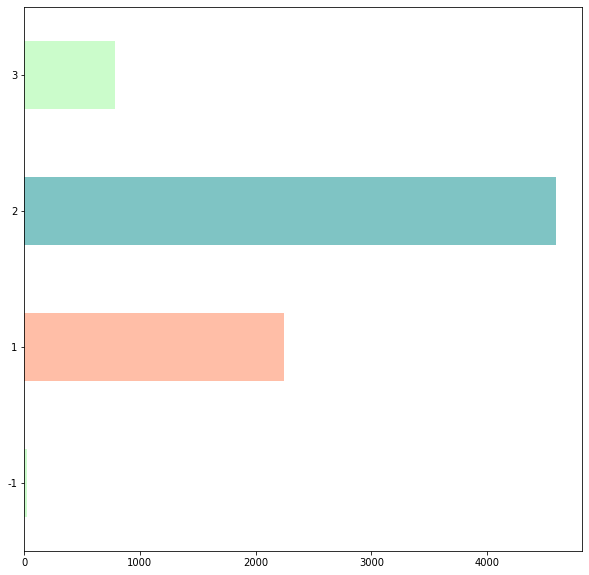

In [14]:
yahoo_users['year_category'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(10,10), color=["palegreen", "coral", "darkcyan"])
plt.show()

<br>

<br><br>

### PODACI 

In [15]:
yahoo_train = pd.read_csv('yahoo_train.txt', sep=",", header=None)
yahoo_train.columns = ["user_id","movie_id","user_age","user_gender","movie_age","rating"]

yahoo_train.head()

,user_id,movie_id,user_age,user_gender,movie_age,rating
0,1,1158,2,1,1,5
1,1,89420,2,1,3,4
2,1,1290,2,1,2,5
3,1,61,2,1,3,5
4,1,39183,2,1,3,4


In [16]:
yahoo_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210111 entries, 0 to 210110
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      210111 non-null  int64
 1   movie_id     210111 non-null  int64
 2   user_age     210111 non-null  int64
 3   user_gender  210111 non-null  int64
 4   movie_age    210111 non-null  int64
 5   rating       210111 non-null  int64
dtypes: int64(6)
memory usage: 9.6 MB


<br>

##### čišćenje podataka

Provedeno je kroz nekoliko koraka.

<br>

Prvo smo obrisali sve retke iz podataka za treniranje, odnosno sve ocjene korisnika, za koje nam nije bila poznata neka od vrijednosti stupaca. Na primjer, ako nismo znali godinu rođenja osobe.

In [ ]:
#yahoo_train = yahoo_train.drop(yahoo_train[yahoo_train["user_id"].isin(leave_out_train_users)].index)
#yahoo_train.info()

<br>

Onda smo maknuli sve retke koji su za yahoo_id imali vrijednost $0$, što je očito nevaljala informacija, jer ne postoji takav film. Dakle, uklonili smo sljedeće podatke. 
<br>

<i>Napomena: Ove četvorke su uzete iz orginalne train datoteke. Što znači da posljednje dvije vrijednosti označavaju ocjenu u rasponu 1-13, odnosno 1-5.</i>

* (131,0,8,4) 
* (7297,0,13,5)
* (7243,0,13,5)
* (7189,0,2,2)
* (6761,0,13,5)
* (6595,0,11,5)
* (6512,0,13,5)
* (5930,0,13,5)
* (5479,0,13,5)
* (4885,0,10,4)
* (4526,0,12,5)
* (4501,0,12,5)
* (4459,0,12,5)
* (4447,0,1,1)
* (4336,0,12,5)
* (4110,0,8,4)
* (4074,0,13,5)
* (3760,0,10,4)
* (3721,0,12,5)
* (3176,0,13,5)
* (3014,0,13,5)
* (2869,0,12,5)
* (2390,0,6,3)
* (2239,0,13,5)
* (1871,0,9,4)
* (1364,0,13,5)
* (1278,0,3,2)
* (1150,0,1,1)
* (1017,0,13,5)
* (844,0,13,5)
* (509,0,7,3)
* (369,0,9,4)
* (346,0,9,4)
* (197,0,13,5)

In [ ]:
#category_age_user = []
#category_movie = []
#gender_user = []
#
#for index, row in yahoo_train.iterrows():
#    cat1 = yahoo_users[ yahoo_users["user_id"] == row["user_id"] ]["year_category"].ravel()
#    cat2 = yahoo_movies[yahoo_movies["yahoo_id"] == row["movie_id"]]["year_category"].ravel()
#    cat3 = yahoo_users[ yahoo_users["user_id"] == row["user_id"] ]["gender"].ravel()
#    
#    category_age_user.append(cat1[0])
#    category_movie.append(cat2[0])
#    gender_user.append(cat3[0])

#yahoo_train['user_age'] = category_age_user
#yahoo_train['movie_age'] = category_movie
#yahoo_train['user_gender'] = gender_user
#yahoo_train

<br>

Pogledajmo sada novu distribuciju ocjenjivanja filmova po dobi korisnika. 

In [17]:
yahoo_train['user_age'].value_counts()

2    130317
1     60194
3     19600
Name: user_age, dtype: int64

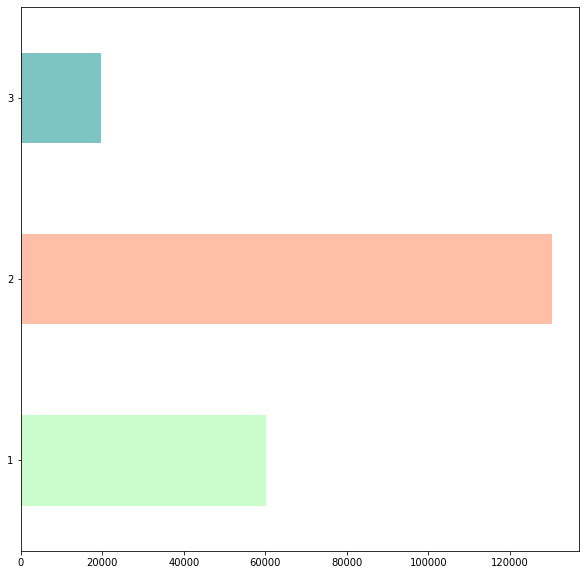

In [18]:
yahoo_train['user_age'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(10,10), color=["palegreen", "coral", "darkcyan"])
plt.show()

Vidimo da je najviše korisnika koji su ocjenili neki sadržaj srednje dobi, dok sadržaj najmanje ocjenjuju najstariji korisnici.

<br>

In [19]:
yahoo_train['movie_age'].value_counts()

3    180525
2     22356
1      7230
Name: movie_age, dtype: int64

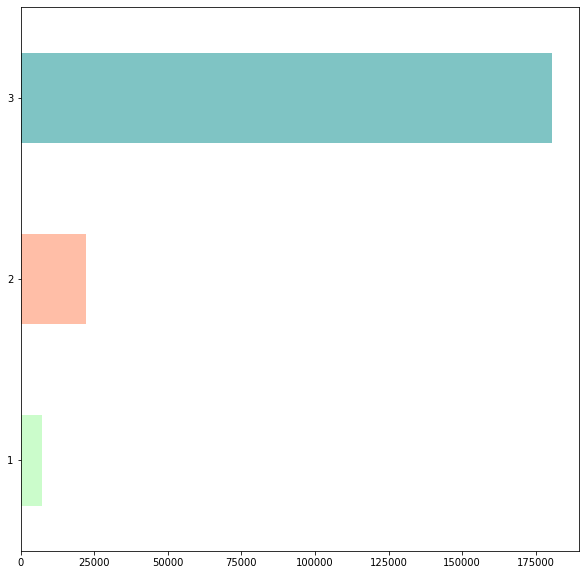

In [20]:
yahoo_train['movie_age'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(10,10), color=["palegreen", "coral", "darkcyan"])
plt.show()

<br><br>


In [21]:
yahoo_train['rating'].value_counts().sort_index()

1     16727
2      8529
3     20201
4     58682
5    105972
Name: rating, dtype: int64

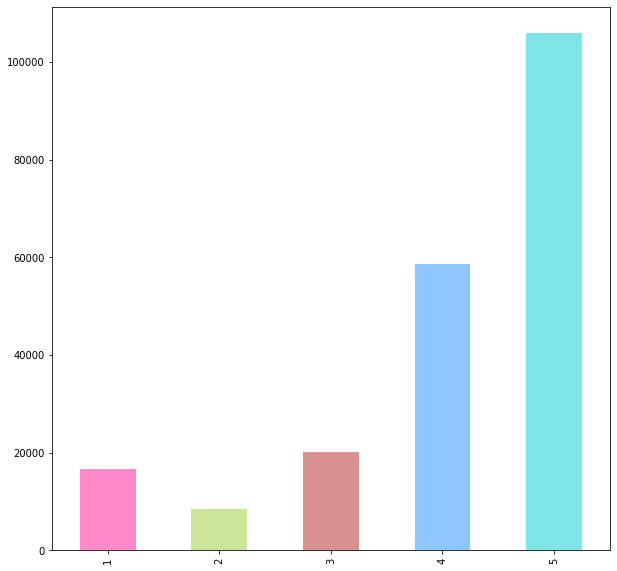

In [22]:
#Visualize overall rating by users
yahoo_train['rating'].value_counts().sort_index().plot(kind='bar',alpha=0.5,figsize=(10,10), color=["deeppink", "yellowgreen", "firebrick", "dodgerblue", "darkturquoise"])
plt.show()

Vidimo da je najviše filmova u _Yahoo_ bazi podataka za treniranje ocjenjeno sa najvećom ocjenom - _5_.

<br><br>

##### isto radimo i za podatke za testiranje

In [23]:
yahoo_test = pd.read_csv('yahoo_test.txt', sep=",", header=None)
yahoo_test.columns = ["user_id","movie_id","user_age","user_gender","movie_age","rating"]

yahoo_test.head()

,user_id,movie_id,user_age,user_gender,movie_age,rating
0,5,95057,1,0,3,4
1,6,37410,2,0,3,5
2,6,90265,2,0,3,5
3,6,82533,2,0,3,5
4,6,183,2,0,3,5


In [24]:
yahoo_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10136 entries, 0 to 10135
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      10136 non-null  int64
 1   movie_id     10136 non-null  int64
 2   user_age     10136 non-null  int64
 3   user_gender  10136 non-null  int64
 4   movie_age    10136 non-null  int64
 5   rating       10136 non-null  int64
dtypes: int64(6)
memory usage: 475.2 KB


In [26]:
yahoo_test[yahoo_test["user_id"].isin(leave_out_train_users)].index

Int64Index([], dtype='int64')

In [ ]:
#category_age_user2 = []
#category_movie2 = []
#gender_user2 = []
#
#for index, row in yahoo_test.iterrows():
#    cat1 = yahoo_users[ yahoo_users["user_id"] == row["user_id"] ]["year_category"].ravel()
#    cat2 = yahoo_movies[yahoo_movies["yahoo_id"] == row["movie_id"]]["year_category"].ravel()
#    cat3 = yahoo_users[ yahoo_users["user_id"] == row["user_id"] ]["gender"].ravel()
#    
#    category_age_user2.append(cat1[0])
#    category_movie2.append(cat2[0])
#    gender_user2.append(cat3[0])
#
#yahoo_test['user_age'] = category_age_user2
#yahoo_test['movie_age'] = category_movie2
#yahoo_test['user_gender'] = gender_user2
#yahoo_test

In [27]:
yahoo_test['user_age'].value_counts()

2    6288
1    2863
3     985
Name: user_age, dtype: int64

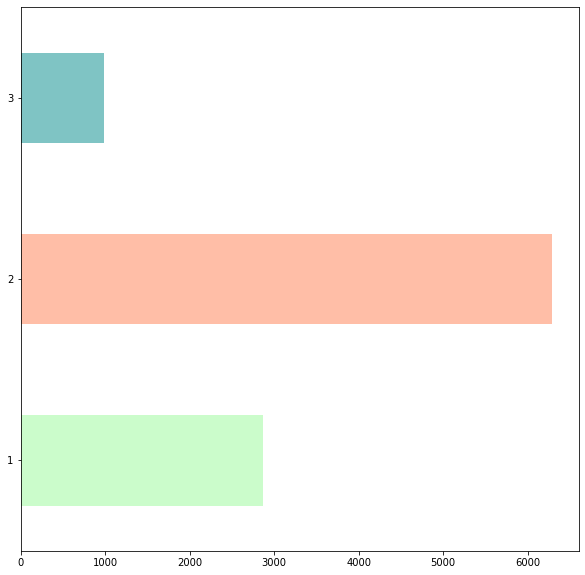

In [28]:
yahoo_test['user_age'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(10,10), color=["palegreen", "coral", "darkcyan"])
plt.show()

In [29]:
yahoo_test['movie_age'].value_counts()

 3    8591
 2    1160
 1     364
-1      21
Name: movie_age, dtype: int64

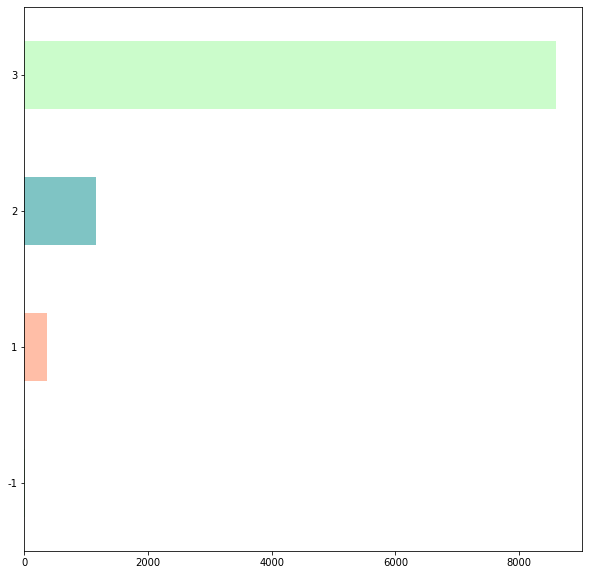

In [30]:
yahoo_test['movie_age'].value_counts().sort_index().plot(kind='barh',alpha=0.5,figsize=(10,10), color=["palegreen", "coral", "darkcyan"])
plt.show()

In [31]:
yahoo_test['rating'].value_counts().sort_index()

1     559
2     387
3    1000
4    3251
5    4939
Name: rating, dtype: int64

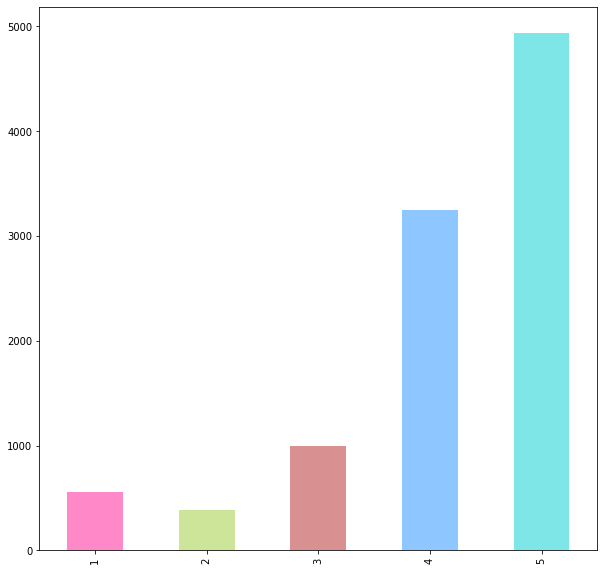

In [32]:
#Visualize overall rating by users
yahoo_test['rating'].value_counts().sort_index().plot(kind='bar',alpha=0.5,figsize=(10,10), color=["deeppink", "yellowgreen", "firebrick", "dodgerblue", "darkturquoise"])
plt.show()

<br><br>


## ADOM DATA

* Place: represents the places where the movie can be seen. Place consists of a single attribute defining the listing of movie theaters and also the choices of the home TV, VCR, and DVD.
* Time: represents the time when the movie can be or has been seen; it is defined by attributes Time(TimeOfDay, DayOfWeek, Month,
Year).
* Companion: represents a person or a group of persons with whom one can see the movie. Companion consists of a single attribute having values “alone,” “friends,” “girlfriend/boyfriend,” “family,” “co-workers,” and “others.”

In [19]:
adom_train = pd.read_csv('../adom/train.txt', sep=",", header=None)
adom_train.columns = ["user_id", "movie_id", "", "companion", "", "", "", "rating"]
#adom_train.columns = ["user_id", "movie_id", "companion", "day_of_week", "opening_weekend", "season", "year_seen", "rating"]
adom_train

,user_id,movie_id,,companion,,,,rating
0,35,97,1,2,4,3,3,13
1,30,85,3,2,2,1,2,9
2,76,136,1,2,2,1,1,6
3,69,28,3,1,3,1,2,12
4,28,18,3,2,3,4,1,6
...,...,...,...,...,...,...,...,...
1167,76,90,1,2,1,4,1,6
1168,61,43,1,4,2,1,1,11
1169,30,22,2,2,2,2,2,11
1170,23,61,1,3,3,1,1,8


84,192,3,5,4,4,5,13

In [21]:
steps_mae_adom = [ 30.3919, 9.4950, 5.6381, 3.1578, 2.9790, 2.9049, 2.8024, 2.7051, 2.6460, 2.6105, 2.6009, 2.5311, 2.518, 2.5412, 2.5415, 2.5818, 2.5539, 2.5480, 2.5464, 2.5450, 2.5479, 2.5465, 2.5599, 2.4803, 2.5181, 2.5261, 2.5009, 2.4839, 2.5022, 2.5018]

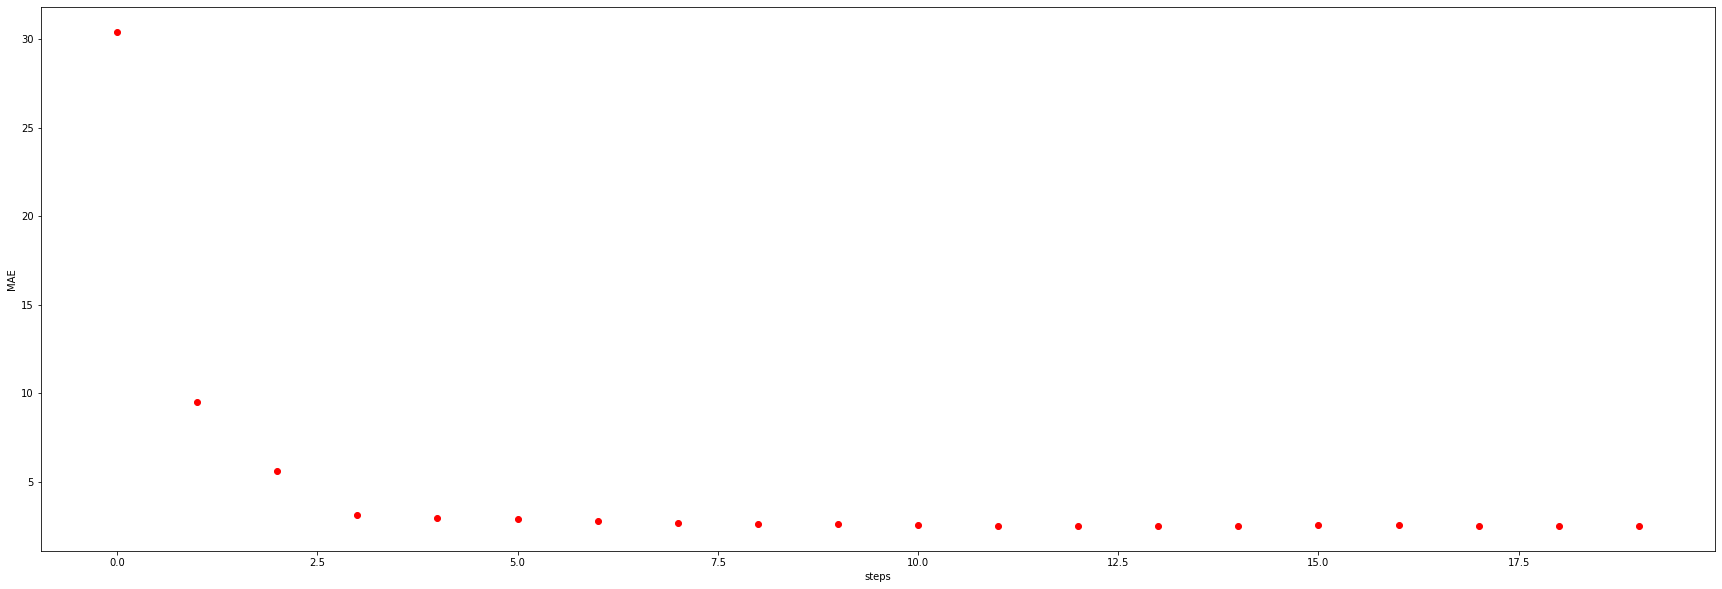

In [33]:
plt.figure(figsize=((30,10)))

plt.plot(steps_mae_adom[0:20],'ro')
plt.ylabel('MAE')
plt.xlabel('steps')
plt.show()

<br><br>

## Rezultati

##### cijeli train za train, cv = 5, d = [20,20,3], 5 steps, alpha = 0.001, beta = 0.1

In [41]:
yahoo_cv1_results = pd.DataFrame()
yahoo_cv1_results['steps'] = [1,2,3,4,5]
yahoo_cv1_results['train_mae'] = [1.0876, 0.9381, 0.8981, 0.8701, 0.8480]
yahoo_cv1_results['cv_mae'] = [0.9668, 0.9236, 0.8913, 0.8734, 0.8532]
yahoo_cv1_results['test_mae'] = [0.9632, 0.9238, 0.9046, 0.8805, 0.8737]
yahoo_cv1_results

,steps,train_mae,cv_mae,test_mae
0,1,1.0876,0.9668,0.9632
1,2,0.9381,0.9236,0.9238
2,3,0.8981,0.8913,0.9046
3,4,0.8701,0.8734,0.8805
4,5,0.8480,0.8532,0.8737


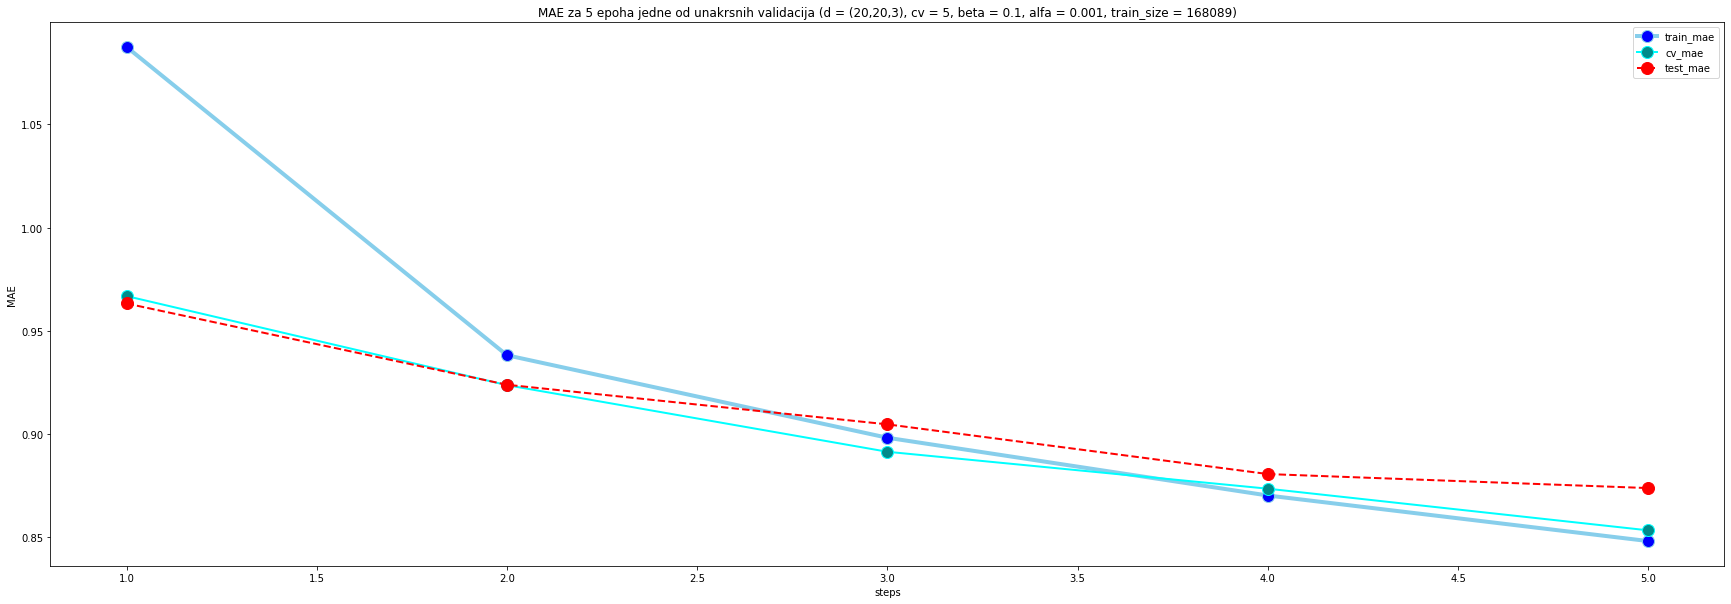

In [42]:
plt.figure(figsize=((30,10)))
plt.title('MAE za 5 epoha jedne od unakrsnih validacija (d = (20,20,3), cv = 5, beta = 0.1, alfa = 0.001, train_size = 168089)')

plt.plot( 'steps', 'train_mae', data=yahoo_cv1_results, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'steps', 'cv_mae', data=yahoo_cv1_results, marker='o', markerfacecolor='darkcyan', markersize=12, color='aqua', linewidth=2)
plt.plot( 'steps', 'test_mae', data=yahoo_cv1_results, marker='o', markersize=12, color='red', linewidth=2, linestyle='dashed')

plt.ylabel('MAE')
plt.xlabel('steps')

plt.legend()
plt.show()

### Recommend movies for user 4633

In [43]:
best100_foruser_4633 = [91999,95223,71325,55279,73559,96130,34677,37333,105741,101528,8568,33772,17071,99037,12349,20382,29920,87908,49071,92770,96756,77933,36376,19911,54478,948,31562,12827,60150,97031,32989,103846,1981,101507,102936,64594,86300,93430,20202,78005,34138,18814,67418,88527,63215,81514,103438,88389,92792,75029,94127,43267,30851,72496,90643,8136,94338,29613,62070,50703,20101,49488,69864,52771,72688,86718,60082,44642,61719,60955,10255,77100,23060,29012,94594,6277,44157,7522,21437,8056,22591,43469,53651,46156,95232,66757,20677,95768,70293,64089,13901,103448,65579,49332,84250,4318,54630,36345,80248,96879]

In [61]:
best100_foruser_4633_names = pd.DataFrame()
names = []

for i in range(100):
    index = best100_foruser_4633[i]
    names.append(yahoo_movies[ yahoo_movies["movie_id"] == str(index) ]["name"].values)
    

In [64]:
best100_foruser_4633_names["movies"] = names

In [66]:
best100_foruser_4633_names.to_csv("best100movies_for_user_4633.csv", index=False)

In [52]:
yahoo_movies[ yahoo_movies["movie_id"] == "91999" ]

,movie_id,yahoo_id,name,year,movie_age
92001,91999,1807645861,Partridge Family Boxed Set 2,1997.0,3
